In [1]:
%matplotlib inline

import os
import requests

import pandas as pd
from shapely.geometry import Point
from geopandas import GeoDataFrame
from fiona.crs import from_epsg

from utils import PHL_CRS, create_point_geometry, reproject_gdf

Read a csv of the addresses

In [2]:
df = pd.read_csv('../data/addresses.csv')

Put the addresses through AIS (PHL's internal Address Information System)

In [3]:
GATEKEEPERKEY = os.getenv('GATEKEEPERKEY')

for index, row in df.iterrows():
    address = row['Address']
    try:
        r = requests.get(f'https://api.phila.gov/ais/v1/search/{address}?gatekeeperKey={GATEKEEPERKEY}').json()
        df.loc[index, 'X'] = r['features'][0]['geometry']['coordinates'][0]
        df.loc[index, 'Y'] = r['features'][0]['geometry']['coordinates'][1]
    except KeyError:
        print(address + ' failed to go through AIS.')

Convert XY coordinates to shapely Points

In [4]:
geometry = create_point_geometry(df=df, x_col='X', y_col='Y')

Transform the pandas dataframe to a geopandas geodataframe

In [5]:
gdf = GeoDataFrame(df, geometry=geometry)

Reproject the data to the coordinate system used by the city

In [6]:
gdf = reproject_gdf(gdf=gdf, start_crs=4326, end_crs=PHL_CRS)

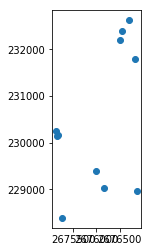

In [7]:
gdf.plot()

In [8]:
# Save to a shapefile
gdf.to_file('../data/remediations.shp')